# Análise Experimental do Sistema de Consultas Logísticas (v2)

Este notebook utiliza o `Makefile` para gerar as entradas e orquestra a análise de performance do sistema.

In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import os

# Configurações do diretório
project_dir = os.getcwd()
bin_path = os.path.join(project_dir, 'bin/tp3.out')
input_path = os.path.join(project_dir, 'inputs/random_input.txt')

## Funções Auxiliares para Execução e Coleta de Métricas

In [2]:
def run_experiment(params):
    """Executa um único experimento: gera a entrada via make, roda a simulação e coleta os dados."""
    try:
        # 1. Gerar o arquivo de entrada usando 'make gen-input' com variáveis
        make_command = ['make', 'gen-input']
        for key, value in params.items():
            make_command.append(f'{key.upper()}={value}')
        
        # Garante que o programa principal está compilado
        subprocess.run(['make', 'all'], cwd=project_dir, check=True, capture_output=True, text=True)
        
        # Gera a entrada
        gen_result = subprocess.run(make_command, cwd=project_dir, check=True, capture_output=True, text=True)

        # 2. Executar o programa com medição de tempo e memória
        command = ['/usr/bin/time', '-v', bin_path, input_path, '--timed']
        sim_result = subprocess.run(command, capture_output=True, text=True)
        
        # 3. Extrair métricas da saída de erro (stderr)
        stderr_output = sim_result.stderr

        time_match = re.search(r'Processing time: (\d+\.?\d*) ms', stderr_output)
        processing_time_ms = float(time_match.group(1)) if time_match else None

        mem_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', stderr_output)
        max_memory_kb = int(mem_match.group(1)) if mem_match else None
        
        if sim_result.returncode != 0:
            print(f'Erro na simulação com parâmetros {params}:')
            print('STDERR:', stderr_output)
            return None

        return {'params': params, 'time_ms': processing_time_ms, 'memory_kb': max_memory_kb}

    except subprocess.CalledProcessError as e:
        print(f'Erro no processo com parâmetros {params}:')
        print('COMMAND:', e.cmd)
        print('STDERR:', e.stderr)
        return None
    except Exception as e:
        print(f'Uma exceção inesperada ocorreu: {e}')
        return None

## Definição e Execução dos Experimentos

In [3]:
results = []
base_params = {'nodes': 10, 'packets': 1000, 'clients': 500, 'num_cl': 100, 'num_pc': 100, 'seed': 42}

# Experimento 1: Variando o número de pacotes
print('--- Experimento 1: Variando Pacotes ---')
for num_packets in np.linspace(1000, 10000, 20,dtype=int):
    params = base_params.copy()
    params['packets'] = num_packets
    print(f'Testando com {num_packets} pacotes...')
    result = run_experiment(params)
    if result: results.append(result)

# Experimento 2: Variando o número de clientes
print('\n--- Experimento 2: Variando Clientes ---')
for num_clients in np.linspace(500,5000,20,dtype=int):
    params = base_params.copy()
    params['clients'] = num_clients
    print(f'Testando com {num_clients} clientes...')
    result = run_experiment(params)
    if result: results.append(result)

# Experimento 3: Variando o número de consultas
print('\n--- Experimento 3: Variando Consultas CL ---')
for num_queries in np.linspace(100,1000,20,dtype=int):
    params = base_params.copy()
    params['num_cl'] = num_queries
    print(f'Testando com {num_queries} consultas CL...')
    result = run_experiment(params)
    if result: results.append(result)

print('\n--- Experimento 4: Variando Consultas PC---')
for num_queries in np.linspace(100,1000,20,dtype=int):
    params = base_params.copy()
    params['num_pc'] = num_queries
    print(f'Testando com {num_queries} consultas PC...')
    result = run_experiment(params)
    if result: results.append(result)

# Converter resultados para DataFrame
df_results_raw = pd.DataFrame(results)
df_params = pd.json_normalize(df_results_raw['params'])
df_metrics = df_results_raw[['time_ms', 'memory_kb']].reset_index(drop=True)
df_results = pd.concat([df_params, df_metrics], axis=1)
df_results.to_csv('experimental_results.csv', index=False)
print('\nExperimentos concluídos! Resultados salvos em experimental_results.csv')
display(df_results)

--- Experimento 1: Variando Pacotes ---
Testando com 1000 pacotes...
Testando com 1473 pacotes...
Testando com 1947 pacotes...
Testando com 2421 pacotes...
Testando com 2894 pacotes...
Testando com 3368 pacotes...
Testando com 3842 pacotes...
Testando com 4315 pacotes...
Testando com 4789 pacotes...
Testando com 5263 pacotes...
Testando com 5736 pacotes...
Testando com 6210 pacotes...
Testando com 6684 pacotes...
Testando com 7157 pacotes...
Testando com 7631 pacotes...
Testando com 8105 pacotes...
Testando com 8578 pacotes...
Testando com 9052 pacotes...
Testando com 9526 pacotes...
Testando com 10000 pacotes...

--- Experimento 2: Variando Clientes ---
Testando com 500 clientes...
Testando com 736 clientes...
Testando com 973 clientes...
Testando com 1210 clientes...
Testando com 1447 clientes...
Testando com 1684 clientes...
Testando com 1921 clientes...
Testando com 2157 clientes...
Testando com 2394 clientes...
Testando com 2631 clientes...
Testando com 2868 clientes...
Testando c

,nodes,packets,clients,num_cl,num_pc,seed,time_ms,memory_kb
0,10,1000,500,100,100,42,6.21328,4224
1,10,1473,500,100,100,42,8.90743,4224
2,10,1947,500,100,100,42,11.37200,4480
3,10,2421,500,100,100,42,13.88680,4736
4,10,2894,500,100,100,42,15.97180,4608
...,...,...,...,...,...,...,...,...
75,10,1000,500,100,810,42,9.10210,4096
76,10,1000,500,100,857,42,10.07740,4096
77,10,1000,500,100,905,42,9.79205,4224
78,10,1000,500,100,952,42,12.89300,4096


## Visualização dos Resultados

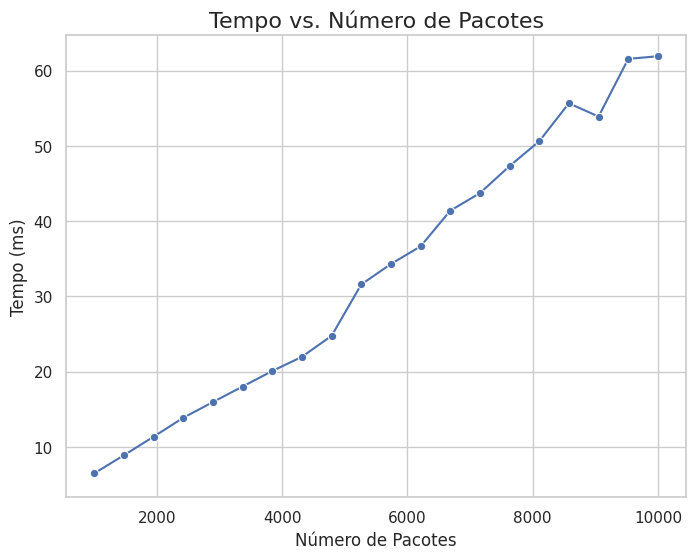

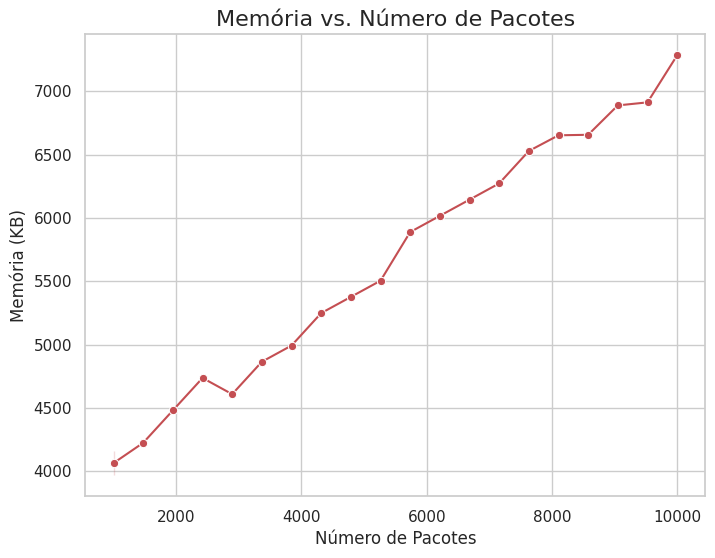

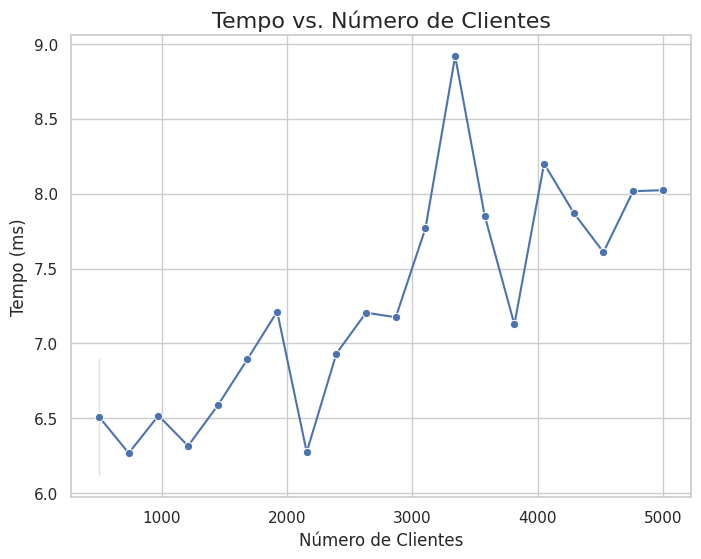

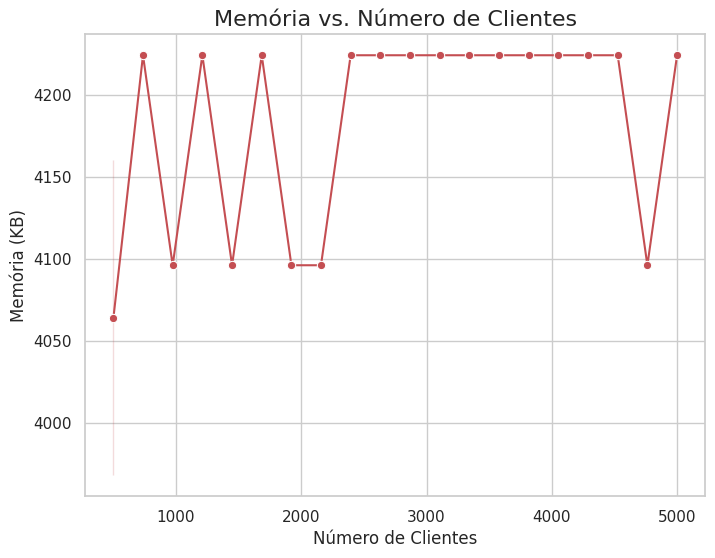

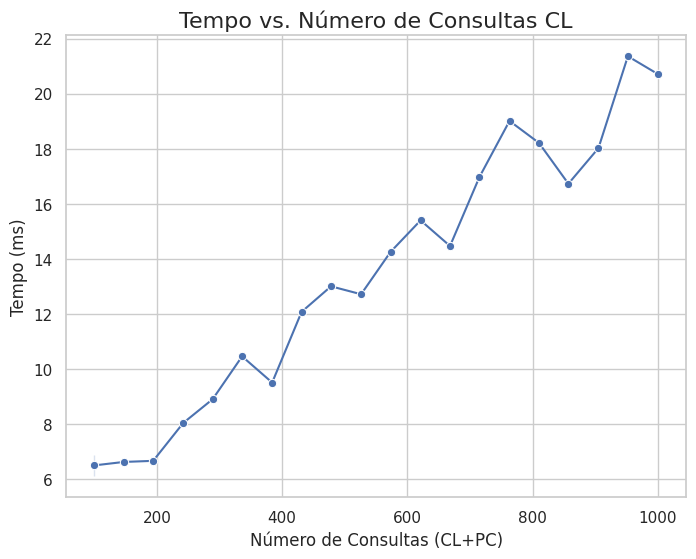

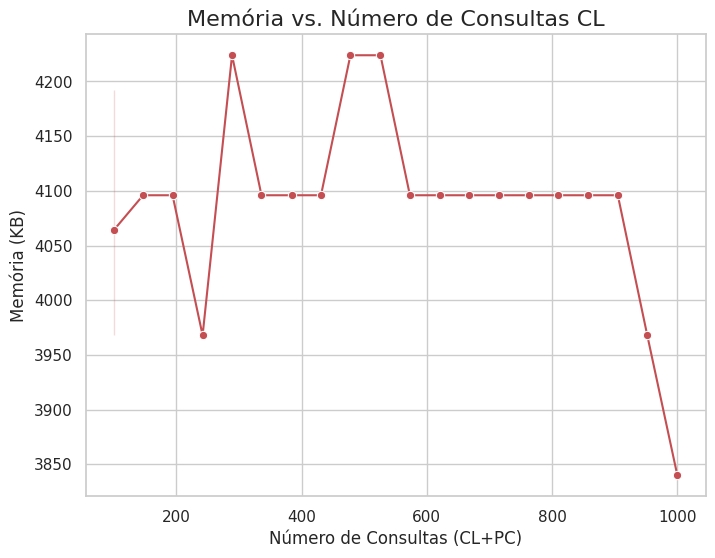

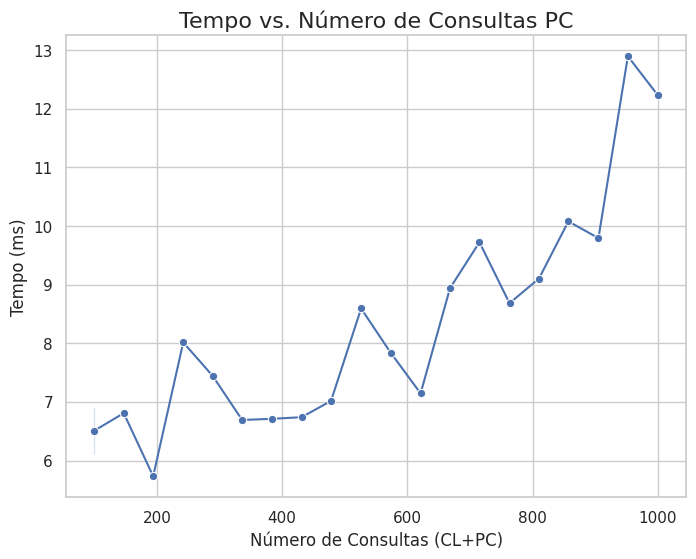

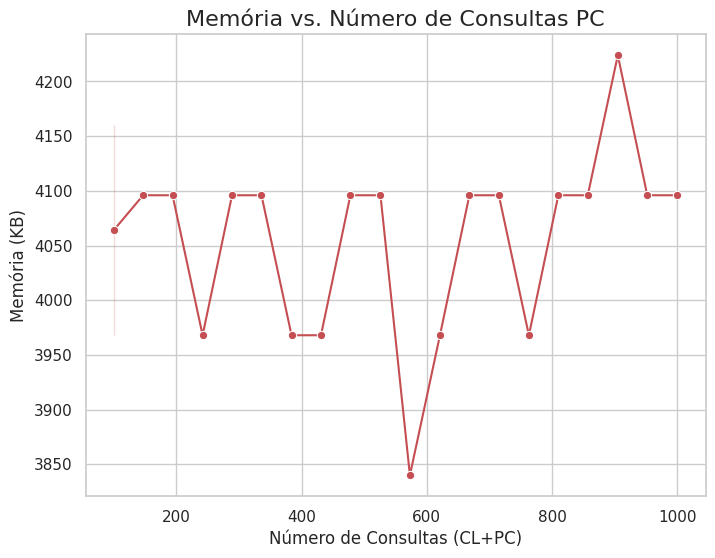

Gráficos salvos com sucesso no diretório 'resultados'!


In [ ]:
output_dir = 'resultados'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Estilo dos gráficos
sns.set_theme(style="whitegrid")

# Filtrar os dataframes
df_packets = df_results[(df_results['clients'] == base_params['clients']) & (df_results['num_cl'] == base_params['num_cl']) & (df_results['num_pc'] == base_params['num_pc'])]
df_clients = df_results[(df_results['packets'] == base_params['packets']) & (df_results['num_cl'] == base_params['num_cl']) & (df_results['num_pc'] == base_params['num_pc'])]
df_queries_cl = df_results[(df_results['packets'] == base_params['packets']) & (df_results['clients'] == base_params['clients']) & (df_results['num_pc'] == base_params['num_pc'])]
df_queries_pc = df_results[(df_results['packets'] == base_params['packets']) & (df_results['clients'] == base_params['clients']) & (df_results['num_cl'] == base_params['num_cl'])]

# Dicionário para simplificar a criação dos gráficos
plots_to_save = {
    "tempo_vs_pacotes.png": {'data': df_packets, 'x': 'packets', 'y': 'time_ms', 'title': 'Tempo vs. Número de Pacotes', 'xlabel': 'Número de Pacotes', 'ylabel': 'Tempo (ms)', 'color': 'b'},
    "memoria_vs_pacotes.png": {'data': df_packets, 'x': 'packets', 'y': 'memory_kb', 'title': 'Memória vs. Número de Pacotes', 'xlabel': 'Número de Pacotes', 'ylabel': 'Memória (KB)', 'color': 'r'},
    "tempo_vs_clientes.png": {'data': df_clients, 'x': 'clients', 'y': 'time_ms', 'title': 'Tempo vs. Número de Clientes', 'xlabel': 'Número de Clientes', 'ylabel': 'Tempo (ms)', 'color': 'b'},
    "memoria_vs_clientes.png": {'data': df_clients, 'x': 'clients', 'y': 'memory_kb', 'title': 'Memória vs. Número de Clientes', 'xlabel': 'Número de Clientes', 'ylabel': 'Memória (KB)', 'color': 'r'},
    "tempo_vs_consultas_cl.png": {'data': df_queries_cl, 'x': 'num_cl', 'y': 'time_ms', 'title': 'Tempo vs. Número de Consultas CL', 'xlabel': 'Número de Consultas (CL+PC)', 'ylabel': 'Tempo (ms)', 'color': 'b'},
    "memoria_vs_consultas_cl.png": {'data': df_queries_cl, 'x': 'num_cl', 'y': 'memory_kb', 'title': 'Memória vs. Número de Consultas CL', 'xlabel': 'Número de Consultas (CL+PC)', 'ylabel': 'Memória (KB)', 'color': 'r'},
    "tempo_vs_consultas_pc.png": {'data': df_queries_pc, 'x': 'num_pc', 'y': 'time_ms', 'title': 'Tempo vs. Número de Consultas PC', 'xlabel': 'Número de Consultas (CL+PC)', 'ylabel': 'Tempo (ms)', 'color': 'b'},
    "memoria_vs_consultas_pc.png": {'data': df_queries_pc, 'x': 'num_pc', 'y': 'memory_kb', 'title': 'Memória vs. Número de Consultas PC', 'xlabel': 'Número de Consultas (CL+PC)', 'ylabel': 'Memória (KB)', 'color': 'r'}
}

# 2. Gerar e salvar cada gráfico individualmente
for filename, params in plots_to_save.items():
    plt.figure(figsize=(8, 6)) # Cria uma nova figura para cada gráfico
    
    ax = sns.lineplot(data=params['data'], x=params['x'], y=params['y'], marker='o', color=params['color'])
    
    ax.set_title(params['title'], fontsize=16)
    ax.set_xlabel(params['xlabel'])
    ax.set_ylabel(params['ylabel'])
    
    # Constrói o caminho completo do arquivo e salva a figura
    file_path = os.path.join(output_dir, filename)
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    plt.close() # Fecha a figura para liberar memória

print(f"Gráficos salvos com sucesso no diretório '{output_dir}'!")